In [1]:
import sys, glob, os
SPARK_HOME=os.environ['SPARK_HOME']
sys.path.append(SPARK_HOME + "/python")
sys.path.append(glob.glob(SPARK_HOME + "/python/lib/py4j*.zip")[0])


from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql.window import Window, WindowSpec


conf = (SparkConf()
        .setAppName("PySpark Application")
        .setIfMissing("spark.master", "local[*]")
        .setIfMissing("spark.local.dir", "/tmp/spark")
        .setIfMissing("spark.driver.memory", "5G")
        .setIfMissing("spark.driver.cores", "4")
        .setIfMissing("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.4-s_2.11")
     
       )

spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext
print(sc.uiWebUrl)

sql = spark.sql

http://192.168.20.118:4040


In [3]:
from graphframes import GraphFrame

In [6]:
vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50), 
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])
edges = spark.createDataFrame([('1', '2', 'friend'), 
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])
g = GraphFrame(vertices, edges)
## Take a look at the DataFrames
print("Veritices")
g.vertices.show()
print("Edges")
g.edges.show()
print("Degrees")
g.degrees.show()

Veritices
+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+

Edges
+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+

Degrees
+---+------+
| id|degree|
+---+------+
|  3|     7|
| 98|     2|
| 99|     2|
|  5|     3|
|  1|     4|
|  4|     3|
|  2|     3|
+---+------+



In [35]:
nodes = list(map(lambda r: r.id, g.vertices.select("id").collect()))
nodes

['1', '2', '3', '4', '5', '98', '99']

In [40]:
edges = [(r.src, r.dst) for r in g.edges.select("src", "dst").collect()]
edges

[('1', '2'),
 ('2', '1'),
 ('3', '1'),
 ('1', '3'),
 ('2', '3'),
 ('3', '4'),
 ('4', '3'),
 ('5', '3'),
 ('3', '5'),
 ('4', '5'),
 ('98', '99'),
 ('99', '98')]

# Drawing graph using networkx

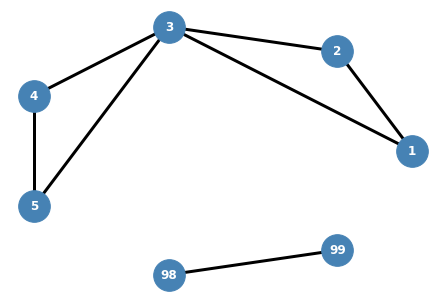

In [52]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

options = {
    'node_color': 'steelblue',
    "font_color": "white",
    'node_size': 1000,
    'width': 3,
    'font_weight': 'bold'
}

nx.draw_shell(G, with_labels=True, **options)

In [8]:
edges.where("src<dst").show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
+---+---+-------+



In [10]:
g.edges.filter('type == "friend"').show()

+---+---+------+
|src|dst|  type|
+---+---+------+
|  1|  2|friend|
|  2|  1|friend|
|  3|  1|friend|
|  1|  3|friend|
|  3|  4|friend|
|  4|  3|friend|
|  5|  3|friend|
|  3|  5|friend|
| 98| 99|friend|
| 99| 98|friend|
+---+---+------+



In [12]:
sc.setCheckpointDir("/tmp/spark-checkpoint")

In [13]:
g.connectedComponents().show()

+---+------+---------+---+------------+
| id|  name|firstname|age|   component|
+---+------+---------+---+------------+
|  1|Carter|  Derrick| 50|154618822656|
|  2|   May|  Derrick| 26|154618822656|
|  3| Mills|     Jeff| 80|154618822656|
|  4|  Hood|   Robert| 65|154618822656|
|  5| Banks|     Mike| 93|154618822656|
| 98|  Berg|      Tim| 28|317827579904|
| 99|  Page|    Allan| 16|317827579904|
+---+------+---------+---+------------+



# Motif finding

Finding motifs helps to execute queries to discover structural patterns in graphs. Network motifs are patterns that occur repeatedly in the graph and represent the relationships between the vertices. GraphFrames motif finding uses a declarative Domain Specific Language (DSL) for expressing structural queries.
The query can be invoked by using the find-function, where the motif (in quotation marks) is expressed as the first parameter of the function.
The following example will search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph, with columns for each of the named elements (vertices or edges) in the motif.

In [15]:
g.find("(a)-[e]->(b); (b)-[e2]->(c)").show()

+--------------------+----------------+--------------------+----------------+--------------------+
|                   a|               e|                   b|              e2|                   c|
+--------------------+----------------+--------------------+----------------+--------------------+
|[3, Mills, Jeff, 80]|  [3, 5, friend]|[5, Banks, Mike, 93]|  [5, 3, friend]|[3, Mills, Jeff, 80]|
|[4, Hood, Robert,...| [4, 5, follows]|[5, Banks, Mike, 93]|  [5, 3, friend]|[3, Mills, Jeff, 80]|
|[3, Mills, Jeff, 80]|  [3, 1, friend]|[1, Carter, Derri...|  [1, 3, friend]|[3, Mills, Jeff, 80]|
|[2, May, Derrick,...|  [2, 1, friend]|[1, Carter, Derri...|  [1, 3, friend]|[3, Mills, Jeff, 80]|
|[3, Mills, Jeff, 80]|  [3, 4, friend]|[4, Hood, Robert,...|  [4, 3, friend]|[3, Mills, Jeff, 80]|
|[1, Carter, Derri...|  [1, 2, friend]|[2, May, Derrick,...| [2, 3, follows]|[3, Mills, Jeff, 80]|
| [98, Berg, Tim, 28]|[98, 99, friend]|[99, Page, Allan,...|[99, 98, friend]| [98, Berg, Tim, 28]|
|[99, Page

In [21]:
mutualFriends = (g
                 .find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)")
                 .dropDuplicates()
                )

mutualFriends.show(100, False)

+------------------------+------------------------+------------------------+
|a                       |b                       |c                       |
+------------------------+------------------------+------------------------+
|[4, Hood, Robert, 65]   |[3, Mills, Jeff, 80]    |[4, Hood, Robert, 65]   |
|[3, Mills, Jeff, 80]    |[1, Carter, Derrick, 50]|[2, May, Derrick, 26]   |
|[5, Banks, Mike, 93]    |[3, Mills, Jeff, 80]    |[1, Carter, Derrick, 50]|
|[4, Hood, Robert, 65]   |[3, Mills, Jeff, 80]    |[1, Carter, Derrick, 50]|
|[3, Mills, Jeff, 80]    |[1, Carter, Derrick, 50]|[3, Mills, Jeff, 80]    |
|[5, Banks, Mike, 93]    |[3, Mills, Jeff, 80]    |[5, Banks, Mike, 93]    |
|[5, Banks, Mike, 93]    |[3, Mills, Jeff, 80]    |[4, Hood, Robert, 65]   |
|[1, Carter, Derrick, 50]|[2, May, Derrick, 26]   |[1, Carter, Derrick, 50]|
|[1, Carter, Derrick, 50]|[3, Mills, Jeff, 80]    |[4, Hood, Robert, 65]   |
|[2, May, Derrick, 26]   |[1, Carter, Derrick, 50]|[3, Mills, Jeff, 80]    |

In [23]:
mutualFriends.printSchema()

root
 |-- a: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- firstname: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- b: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- firstname: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- c: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- firstname: string (nullable = true)
 |    |-- age: long (nullable = true)



To query all the mutual friends between 2 and 3 we can filter the DataFrame.

In [25]:
mutualFriends.filter('a.id == 2 and c.id == 3').show(10, False)

+---------------------+------------------------+--------------------+
|a                    |b                       |c                   |
+---------------------+------------------------+--------------------+
|[2, May, Derrick, 26]|[1, Carter, Derrick, 50]|[3, Mills, Jeff, 80]|
+---------------------+------------------------+--------------------+



# Triangle Count

In [26]:
g.triangleCount().show()

+-----+---+------+---------+---+
|count| id|  name|firstname|age|
+-----+---+------+---------+---+
|    2|  3| Mills|     Jeff| 80|
|    0| 98|  Berg|      Tim| 28|
|    0| 99|  Page|    Allan| 16|
|    1|  5| Banks|     Mike| 93|
|    1|  1|Carter|  Derrick| 50|
|    1|  4|  Hood|   Robert| 65|
|    1|  2|   May|  Derrick| 26|
+-----+---+------+---------+---+



# Page Rank

In [53]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

+---+------+---------+---+------------------+
| id|  name|firstname|age|          pagerank|
+---+------+---------+---+------------------+
|  1|Carter|  Derrick| 50|0.9055074972891308|
|  3| Mills|     Jeff| 80| 1.853919642738813|
|  2|   May|  Derrick| 26|0.5377967999474921|
|  4|  Hood|   Robert| 65|0.6873519241384106|
| 98|  Berg|      Tim| 28|1.0225331112091938|
|  5| Banks|     Mike| 93|0.9703579134677663|
| 99|  Page|    Allan| 16|1.0225331112091938|
+---+------+---------+---+------------------+

+---+---+-------+------------------+
|src|dst|   type|            weight|
+---+---+-------+------------------+
|  1|  2| friend|               0.5|
| 99| 98| friend|               1.0|
|  1|  3| friend|               0.5|
|  4|  5|follows|               0.5|
|  5|  3| friend|               1.0|
| 98| 99| friend|               1.0|
|  3|  5| friend|0.3333333333333333|
|  4|  3| friend|               0.5|
|  2|  1| friend|               0.5|
|  3|  4| friend|0.3333333333333333|
|  3|  1| fr

# Shortest Path

In [56]:
g.shortestPaths(landmarks=["1", "5"]).show()

+---+------+---------+---+----------------+
| id|  name|firstname|age|       distances|
+---+------+---------+---+----------------+
|  1|Carter|  Derrick| 50|[1 -> 0, 5 -> 2]|
|  3| Mills|     Jeff| 80|[5 -> 1, 1 -> 1]|
|  2|   May|  Derrick| 26|[1 -> 1, 5 -> 2]|
|  4|  Hood|   Robert| 65|[5 -> 1, 1 -> 2]|
| 98|  Berg|      Tim| 28|              []|
|  5| Banks|     Mike| 93|[5 -> 0, 1 -> 2]|
| 99|  Page|    Allan| 16|              []|
+---+------+---------+---+----------------+

